### Proyecto final - Karime Jiménez Romero

Utilizando dataset *Clasificación Brain Tumor*

In [72]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scikeras.utils.random_state import tensorflow_random_state
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from sklearn.utils import shuffle
from PIL import Image
from tensorflow.python.keras.callbacks import EarlyStopping

In [2]:
testing = r"C:\Users\karim\OneDrive\Documentos\Neurociencias-2025-2\S06_proyecto\dataset\Testing"
training = r"C:\Users\karim\OneDrive\Documentos\Neurociencias-2025-2\S06_proyecto\dataset\Training"

In [3]:
main_fold = r"C:\Users\karim\OneDrive\Documentos\Neurociencias-2025-2\S06_proyecto\dataset\Training"
subfolders = [f for f in os.listdir(main_fold) if os.path.isdir(os.path.join(main_fold,f))]
#agrupar las imagenes
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_fold,folder)
    images = [os.path.join(path, img) for img in os.listdir(path)
                if img.endswith(".jpg")]
    random.shuffle(images)
    folder_images[folder] = images

selected_images = []
folder_cycle = cycle(subfolders)
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:
        selected_images.append(folder_images[folder].pop)

In [4]:
main_fold = r"C:\Users\karim\OneDrive\Documentos\Neurociencias-2025-2\S06_proyecto\dataset\Testing"
subfolders = [f for f in os.listdir(main_fold) if os.path.isdir(os.path.join(main_fold,f))]
#agrupar las imagenes
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_fold,folder)
    images = [os.path.join(path, img) for img in os.listdir(path)
                if img.endswith(".jpg")]
    random.shuffle(images)
    folder_images[folder] = images

selected_images = []
folder_cycle = cycle(subfolders)
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:
        selected_images.append(folder_images[folder].pop)

1. Análisis de dataset

In [6]:
def cnn_preprocess(x):
    return x / 255.0

In [63]:
train_path = ImageDataGenerator(preprocessing_function=cnn_preprocess)
train_generator = train_path.flow_from_directory(
        training,
        target_size=(150,150),
        batch_size=32,
        class_mode='categorical')

train_generator.class_indices

Found 5712 images belonging to 4 classes.


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

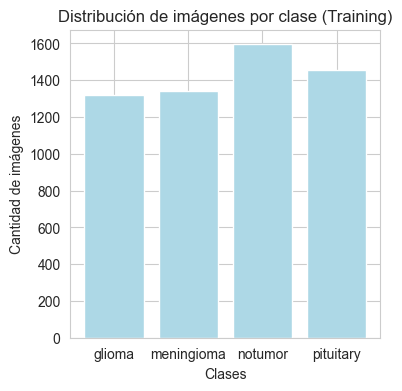

In [8]:
class_names = os.listdir(training)
class_counts = {cls: len(os.listdir(os.path.join(training, cls))) for cls in class_names}
plt.figure(figsize=(4,4))
plt.bar(class_counts.keys(), class_counts.values(), color="lightblue")
plt.title("Distribución de imágenes por clase (Training)")
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.show()

In [64]:
test_path = ImageDataGenerator(preprocessing_function=cnn_preprocess)
test_generator = test_path.flow_from_directory(
        testing,
        target_size=(150,150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
)
test_generator.class_indices

Found 1311 images belonging to 4 classes.


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

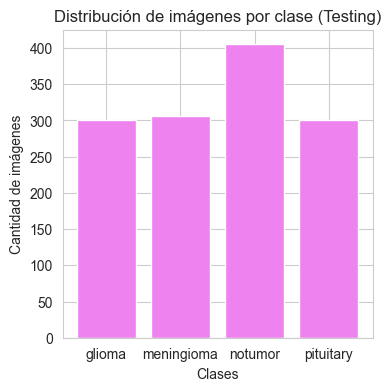

In [10]:
class_names = os.listdir(testing)

class_counts = {cls: len(os.listdir(os.path.join(testing, cls))) for cls in class_names}
plt.figure(figsize=(4,4))
plt.bar(class_counts.keys(), class_counts.values(), color="violet")
plt.title("Distribución de imágenes por clase (Testing)")
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.show()

In [11]:
#verificar tamaños y formatos de imágenes
sizes = []
formats = []

for cls in class_names:
    folder = os.path.join(training, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            sizes.append(img.size)
            formats.append(img.format)
        except:
            print(f"Error al abrir {img_path}")

from collections import Counter

print("Tamaños más comunes (Training):", Counter(sizes).most_common(5))
print("Formatos de imagen:", Counter(formats))

Tamaños más comunes (Training): [((512, 512), 3955), ((225, 225), 268), ((630, 630), 77), ((236, 236), 53), ((201, 251), 43)]
Formatos de imagen: Counter({'JPEG': 5707, 'PNG': 5})


In [12]:
sizes = []
formats = []

for cls in class_names:
    folder = os.path.join(testing, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            sizes.append(img.size)
            formats.append(img.format)
        except:
            print(f"Error al abrir {img_path}")

from collections import Counter

print("Tamaños más comunes (Testing):", Counter(sizes).most_common(5))
print("Formatos de imagen:", Counter(formats))

Tamaños más comunes (Testing): [((512, 512), 787), ((225, 225), 64), ((236, 236), 28), ((227, 222), 17), ((201, 251), 15)]
Formatos de imagen: Counter({'JPEG': 1311})


2. Identificación del tipo de problema

Como se observa, cada carpeta represnta una clase distinta y se clasifican las imágenes en una de esas clases, por lo tanto estamos de hablando de un problema de **clasificación.**


3. Creación de propuestas de modelos

*Modelo CNN*

In [65]:
cnn_model = Sequential([
    Conv2D(filters=32,kernel_size= (3,3), activation="relu", input_shape=(150,150,3), padding= "same"),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=64,kernel_size= (3,3), activation="relu", padding= "same"),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding= "same"),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding= "same"),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dropout(0.6),
    Dense(128,activation= "relu"),
    Dense(4, activation="softmax")

])


C:\Users\karim\PycharmProjects\pythonProject\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
cnn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,045,188 (11.62 MB)

 Trainable params: 3,044,228 (11.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [73]:
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [74]:
es = EarlyStopping (monitor=("val_accuracy"), patience=3, restore_best_weights=True)

history = cnn_model.fit(
        train_generator,
        epochs = 5,
        validation_data = test_generator,
        callbacks = [es]
        )

C:\Users\karim\PycharmProjects\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.7077 - loss: 0.8826 - val_accuracy: 0.4561 - val_loss: 1.5183
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.8741 - loss: 0.3155 - val_accuracy: 0.4966 - val_loss: 1.5354
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.9200 - loss: 0.2085 - val_accuracy: 0.7132 - val_loss: 0.9603
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.9507 - loss: 0.1339 - val_accuracy: 0.9191 - val_loss: 0.2161
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9618 - loss: 0.0953 - val_accuracy: 0.9489 - val_loss: 0.1436


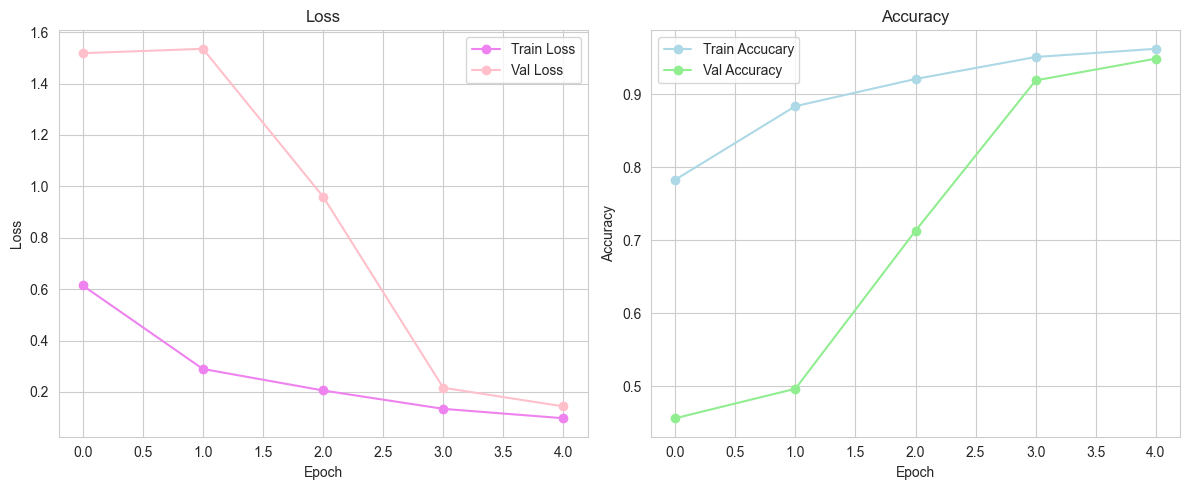

In [75]:
plt.figure(figsize=(12, 5))
#loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss", color="violet", marker= "o")
plt.plot(history.history["val_loss"], label="Val Loss", color="pink", marker= "o")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accucary", color="lightblue", marker= "o")
plt.plot(history.history["val_accuracy"], label="Val Accuracy", color="lightgreen", marker= "o")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

 4. Evaluación de resultados

In [76]:
Y_pred = cnn_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 349ms/step


In [77]:
class_names = list(train_generator.class_indices.keys())

print(classification_report(test_generator.classes, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.98      0.84      0.91       300
  meningioma       0.85      0.95      0.90       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.95      1311
weighted avg       0.95      0.95      0.95      1311



41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 323ms/step


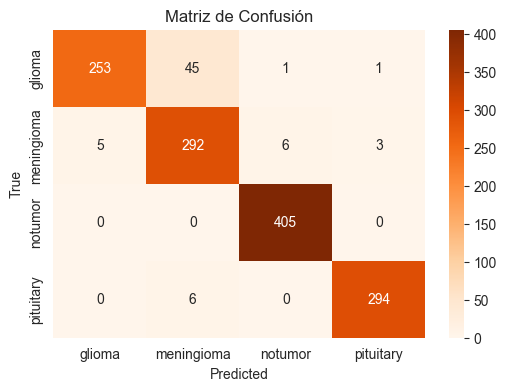

In [78]:
preds = cnn_model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.show()

5. Análisis de resultados

Se fueron realizando varios ajustes a la CNN para poder obtener la accuracy final (0.95%). Los cambios que fui realizando constaban en cambiando las capas, al final agregue 3 bloques con filtros de 64, 128 y 256,  esto para una extracción progresiva de características. Ajuste el dropout a 0.6 para prevenir un sobreajuste.


Este modelo demostró ser mejor al irlo ajustando para la clasificación de imágenes en este trabajo. Su estructura utilizando tres bloques y el valor de Dropout, logró un buen equilibrio entre la extracción de características visuales y la prevención del sobreajuste.